In [44]:
# ! pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna

_FOLDER = "../data/"
_FOLDER2 = "../results/"

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from scipy.optimize import curve_fit

## autoML
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


import json

In [45]:
def createResponseCurve(iD,model, xValues, yValues, predicted = False):
    plt.scatter(xValues, yValues)
    plt.title(model + " " + iD)
    plt.xlabel("Scaled dosage")
    if(predicted):
        plt.ylabel("Predicted Normalised response")
    else:
        plt.ylabel("Normalised response")
    plt.show()


with open(_FOLDER + 'dataSplit.json') as json_file:
    trainTestSplit = json.load(json_file)

In [46]:
drugProfiles = pd.read_csv(_FOLDER+'filteredResponsesWithCCLAndParams.csv')
drugProfiles

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,HDQ-P1,1290922,344,344_1290922,20.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
1,HDQ-P1,1290922,136,136_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
2,HDQ-P1,1290922,170,170_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
3,NMC-G1,908449,170,170_908449,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
4,NMC-G1,908449,331,331_908449,10.24,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,TC-YIK,946357,1011,1011_946357,2.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5580,MKN45,925340,1149,1149_925340,5.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5581,EC-GI-10,753555,1004,1004_753555,0.10,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5582,IGROV-1,905968,1031,1031_905968,0.20,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0


In [47]:
len(trainTestSplit.keys())

88

In [84]:
params = ['param_1', 'param_2','param_3','param_4']
notIncludeColumns = ['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID','MAX_CONC'] + params
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels

predictedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns= ['DRUG_COSMICID']+ resp_labels + params)

for drugId in trainTestSplit.keys():
    drugProfile = drugProfiles[drugProfiles['DRUG_ID'] == int(drugId)]
    tr, val = train_test_split(trainTestSplit[str(drugId)][0], test_size=0.3, random_state=42)

    trainData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(tr)]
    notXValuesFilter = resp_labels + notIncludeColumns + conc_labels
    trainXValues = trainData.drop(columns = notXValuesFilter)
    trainYValues = trainData[resp_labels]
    trainX = trainXValues.reset_index(drop=True).to_numpy()
    trainY = trainYValues.reset_index(drop=True).to_numpy()

    valData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(val)]
    valXValues = valData.drop(columns = notXValuesFilter)
    valYValues = valData[resp_labels]
    valX = valXValues.reset_index(drop=True).to_numpy()
    valY = valYValues.reset_index(drop=True).to_numpy()

    testData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][1])]
    testDataCosmicIds = np.array(testData['DRUGID_COSMICID'])
    testXValues = testData.drop(columns = notXValuesFilter)
    testYValues = testData[resp_labels]
    testParamsValues = testData[params]
    testX = testXValues.reset_index(drop=True).to_numpy()
    testY = testYValues.reset_index(drop=True).to_numpy()
    testParams = testParamsValues.reset_index(drop=True).to_numpy()
    
#     allTrainData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][0])]
#     allTrainDataCosmicIds = np.array(allTrainData['DRUGID_COSMICID'])
#     allTrainXValues = allTrainData.drop(columns = notXValuesFilter)
#     allTrainYValues = allTrainData[resp_labels]
#     allTrainX = allTrainXValues.reset_index(drop=True).to_numpy()
#     allTrainY = allTrainYValues.reset_index(drop=True).to_numpy()


    def objective(trial):
#         params = {
#             'objective': 'reg:squarederror',
#             'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
#             'max_depth': trial.suggest_int('max_depth', 3, 10),
#             'subsample': trial.suggest_uniform('subsample', 0.1, 1),
#             'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
#             'alpha': trial.suggest_loguniform('alpha', 1e-8, 1),
#             'lambda': trial.suggest_loguniform('lambda', 1e-8, 1),
#             'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
#             'n_estimators': trial.suggest_int('n_estimators', 100, 10000)
#         }
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_uniform('subsample', 0.1, 1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
            'alpha': trial.suggest_loguniform('alpha', 1e-8, 1),
            'lambda': trial.suggest_loguniform('lambda', 1e-8, 1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
            'n_estimators': trial.suggest_int('n_estimators', 100, 400)
        }
        model = xgb.XGBRegressor(**params, random_state=42)
        model.fit(trainX, trainY, eval_set=[(valX, valY)], early_stopping_rounds=10, verbose=False)

        valPred = model.predict(valX)
        mse = mean_squared_error(valY, valPred)
        return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=5, n_jobs=-1)
    best_params = study.best_params

    final_model = xgb.XGBRegressor(**best_params, random_state=42)
#     final_model.fit(allTrainX, allTrainY)
    final_model.fit(trainX, trainY)
    preds = final_model.predict(testX)

    result = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    result[pred_resp_labels] = preds
    predictedResults = predictedResults.append(result,ignore_index=True,sort=False)
    test_mse = mean_squared_error(preds, testY)
    trueResult = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    trueResult[resp_labels] = testY
    trueResult[params] = testParams
    trueResults = trueResults.append(trueResult,ignore_index=True,sort=False)

[I 2023-03-06 23:56:59,138] A new study created in memory with name: no-name-aff5a37b-6387-4275-a65e-8ec947a4945f
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
<ipython-input-84-317b1b7fdac8>:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[I 2023-03-06 23:57:05,240] Trial 3 finished with value: 0.17870747879553195 and parameters: {'learning_rate': 0.0006925019399060114, 'max_depth': 3, 'subsample': 0.2781433813229687, 'colsample_bytree': 0.9705975654551866, 'alpha': 2.4265098569851564e-08, 'lambda': 8.81510998232937e-08, 'min_child_weight': 4, 'n_estimators': 128}. Best is trial 3 with value: 0.17870747879553195.
[I 2023-03-06 23:57:05,414] Trial 4 finished with value: 0.0609851281475592 and parameters: {'learning_rate': 0.004522396833618909, 'max_depth': 3, 'subsample': 0.10399002565487259, 'colsample_bytree': 0.2525492782828491, 'alpha': 0.07374932449781962, 'lambda': 6.504908812316046e-06, 'min_child_weight': 12, 'n_estimators': 309}. Best is trial 4 with value: 0.0609851281475592.
[I 2023-03-06 23:57:06,286] Trial 1 finished with value: 0.1858400729115472 and parameters: {'learning_rate': 0.0005738121926358421, 'max_depth': 6, 'subsample': 0.9950297316090582, 'colsample_bytree': 0.8210940991173132, 'alpha': 8.715164

[I 2023-03-06 23:57:15,704] Trial 4 finished with value: 0.13163585151341212 and parameters: {'learning_rate': 0.0005918401125051683, 'max_depth': 9, 'subsample': 0.8966083881767631, 'colsample_bytree': 0.7377914633745493, 'alpha': 3.5724893022806477e-07, 'lambda': 0.145190149087147, 'min_child_weight': 19, 'n_estimators': 280}. Best is trial 4 with value: 0.13163585151341212.
[I 2023-03-06 23:57:15,991] Trial 1 finished with value: 0.13130683696089757 and parameters: {'learning_rate': 0.00042237328730786985, 'max_depth': 10, 'subsample': 0.20591186097691838, 'colsample_bytree': 0.3467404890838225, 'alpha': 3.033635917631453e-06, 'lambda': 3.489846929224865e-07, 'min_child_weight': 13, 'n_estimators': 399}. Best is trial 1 with value: 0.13130683696089757.
[I 2023-03-06 23:57:15,996] Trial 3 finished with value: 0.03101614190798007 and parameters: {'learning_rate': 0.008526859110976824, 'max_depth': 9, 'subsample': 0.7605538834883004, 'colsample_bytree': 0.2636890766205831, 'alpha': 0.0

[I 2023-03-06 23:57:21,487] Trial 0 finished with value: 0.08854286371646156 and parameters: {'learning_rate': 0.0037525116264117515, 'max_depth': 6, 'subsample': 0.5011424068182817, 'colsample_bytree': 0.33541606554900744, 'alpha': 0.10162359252334718, 'lambda': 3.578061615404798e-07, 'min_child_weight': 4, 'n_estimators': 120}. Best is trial 4 with value: 0.018717310623782606.
[I 2023-03-06 23:57:22,775] Trial 3 finished with value: 0.07071801083803586 and parameters: {'learning_rate': 0.0027334536449821235, 'max_depth': 10, 'subsample': 0.20084408312499258, 'colsample_bytree': 0.7734428897808704, 'alpha': 6.3244148334230505e-06, 'lambda': 1.5510073242047202e-05, 'min_child_weight': 2, 'n_estimators': 219}. Best is trial 4 with value: 0.018717310623782606.
[I 2023-03-06 23:57:23,653] Trial 2 finished with value: 0.02654704555569116 and parameters: {'learning_rate': 0.005834466429230409, 'max_depth': 7, 'subsample': 0.9324331728010429, 'colsample_bytree': 0.5129235937344683, 'alpha': 

[I 2023-03-06 23:57:25,997] Trial 3 finished with value: 0.17704371653714207 and parameters: {'learning_rate': 0.00021499657735774805, 'max_depth': 5, 'subsample': 0.6196568840923878, 'colsample_bytree': 0.681079825732914, 'alpha': 3.0457900718388715e-08, 'lambda': 0.00022420596898516107, 'min_child_weight': 15, 'n_estimators': 400}. Best is trial 1 with value: 0.17704371653714207.
[I 2023-03-06 23:57:26,652] Trial 2 finished with value: 0.018105098153494086 and parameters: {'learning_rate': 0.006005665843297192, 'max_depth': 9, 'subsample': 0.49137356180552283, 'colsample_bytree': 0.6381586569967268, 'alpha': 8.389329274203022e-06, 'lambda': 1.0038891440803666e-07, 'min_child_weight': 3, 'n_estimators': 369}. Best is trial 2 with value: 0.018105098153494086.
[I 2023-03-06 23:57:27,229] A new study created in memory with name: no-name-049928b7-e02e-4db9-9ea6-03f86b5da64c
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature wi

[I 2023-03-06 23:57:31,977] Trial 4 finished with value: 0.08352379479865149 and parameters: {'learning_rate': 0.00206600039462446, 'max_depth': 3, 'subsample': 0.6210329655059632, 'colsample_bytree': 0.8085579874915154, 'alpha': 0.000504866750702843, 'lambda': 0.010683844483589175, 'min_child_weight': 2, 'n_estimators': 346}. Best is trial 4 with value: 0.08352379479865149.
[I 2023-03-06 23:57:32,677] A new study created in memory with name: no-name-0b71bec5-7a8b-42f8-ae39-cface2638556
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases

[I 2023-03-06 23:57:36,489] A new study created in memory with name: no-name-df289dde-4188-4788-afc1-86d35ac64196
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
<ipython-input-84-317b1b7fdac8>:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[I 2023-03-06 23:57:41,299] Trial 4 finished with value: 0.041340817242054975 and parameters: {'learning_rate': 0.01045251233644169, 'max_depth': 6, 'subsample': 0.859993335054432, 'colsample_bytree': 0.794559819640597, 'alpha': 0.00022895055675173226, 'lambda': 1.5428665966626377e-05, 'min_child_weight': 20, 'n_estimators': 125}. Best is trial 3 with value: 0.028126612936674816.
[I 2023-03-06 23:57:41,303] Trial 1 finished with value: 0.1717172194723746 and parameters: {'learning_rate': 0.0004313445061369713, 'max_depth': 6, 'subsample': 0.7952523599326633, 'colsample_bytree': 0.7828615797742589, 'alpha': 0.01534652553073103, 'lambda': 0.14999360212303184, 'min_child_weight': 14, 'n_estimators': 131}. Best is trial 3 with value: 0.028126612936674816.
[I 2023-03-06 23:57:42,179] Trial 0 finished with value: 0.052119565550543555 and parameters: {'learning_rate': 0.005310913957265646, 'max_depth': 7, 'subsample': 0.7960892674469623, 'colsample_bytree': 0.7757979434588546, 'alpha': 0.0024

[I 2023-03-06 23:57:45,032] Trial 2 finished with value: 0.017915024541159418 and parameters: {'learning_rate': 0.09272682180397915, 'max_depth': 9, 'subsample': 0.7815460090072226, 'colsample_bytree': 0.8202665813327296, 'alpha': 0.22986971690741229, 'lambda': 0.00023511603774506478, 'min_child_weight': 4, 'n_estimators': 172}. Best is trial 1 with value: 0.017141601985621945.
[I 2023-03-06 23:57:45,385] Trial 4 finished with value: 0.02851950298715441 and parameters: {'learning_rate': 0.008833795180287516, 'max_depth': 3, 'subsample': 0.5314112046389259, 'colsample_bytree': 0.2932871661156172, 'alpha': 2.388777882537114e-08, 'lambda': 1.4155823001925683e-06, 'min_child_weight': 10, 'n_estimators': 156}. Best is trial 1 with value: 0.017141601985621945.
[I 2023-03-06 23:57:46,178] Trial 3 finished with value: 0.08126599236449898 and parameters: {'learning_rate': 0.0014719969209239085, 'max_depth': 10, 'subsample': 0.5342968063978467, 'colsample_bytree': 0.517863941478245, 'alpha': 0.0

[I 2023-03-06 23:57:50,740] Trial 4 finished with value: 0.02538127758531507 and parameters: {'learning_rate': 0.01092626169312698, 'max_depth': 7, 'subsample': 0.20742898521597886, 'colsample_bytree': 0.2354665013779958, 'alpha': 0.07937043634570849, 'lambda': 0.19632897119759593, 'min_child_weight': 6, 'n_estimators': 256}. Best is trial 4 with value: 0.02538127758531507.
[I 2023-03-06 23:57:52,257] Trial 1 finished with value: 0.15875372040881025 and parameters: {'learning_rate': 0.00011121592140543498, 'max_depth': 7, 'subsample': 0.8888685092972577, 'colsample_bytree': 0.961170751302488, 'alpha': 1.453792750958534e-05, 'lambda': 0.00432728816093518, 'min_child_weight': 10, 'n_estimators': 311}. Best is trial 4 with value: 0.02538127758531507.
[I 2023-03-06 23:57:52,733] A new study created in memory with name: no-name-ccb5a7d3-c973-4725-a2af-8ef51fab581a
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remove

[I 2023-03-06 23:57:58,756] Trial 1 finished with value: 0.029996558807585172 and parameters: {'learning_rate': 0.007037926537304792, 'max_depth': 7, 'subsample': 0.617394926363918, 'colsample_bytree': 0.3880310508642818, 'alpha': 2.243165586039479e-06, 'lambda': 0.5883289698310008, 'min_child_weight': 7, 'n_estimators': 226}. Best is trial 3 with value: 0.023492088246549143.
[I 2023-03-06 23:57:59,218] A new study created in memory with name: no-name-901e7538-1c71-4ca7-a992-825d2e9c5b03
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/release

[I 2023-03-06 23:58:00,856] A new study created in memory with name: no-name-1fa0d441-3418-4d53-9e26-a3d51461b698
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
<ipython-input-84-317b1b7fdac8>:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[I 2023-03-06 23:58:03,728] Trial 3 finished with value: 0.10355555491629564 and parameters: {'learning_rate': 0.006767621380849258, 'max_depth': 6, 'subsample': 0.2983741112224174, 'colsample_bytree': 0.18038961715757112, 'alpha': 8.357234711160121e-05, 'lambda': 0.38002883520372005, 'min_child_weight': 10, 'n_estimators': 159}. Best is trial 3 with value: 0.10355555491629564.
[I 2023-03-06 23:58:03,803] Trial 4 finished with value: 0.11327597883810428 and parameters: {'learning_rate': 0.001537221682824818, 'max_depth': 5, 'subsample': 0.38486896126462167, 'colsample_bytree': 0.2510136828318103, 'alpha': 5.985482196875007e-08, 'lambda': 0.0017698286053956188, 'min_child_weight': 10, 'n_estimators': 182}. Best is trial 3 with value: 0.10355555491629564.
[I 2023-03-06 23:58:04,012] Trial 0 finished with value: 0.07051983136914532 and parameters: {'learning_rate': 0.0016434315803017445, 'max_depth': 6, 'subsample': 0.8142784369666493, 'colsample_bytree': 0.5980504969679719, 'alpha': 1.59

[I 2023-03-06 23:58:06,195] Trial 4 finished with value: 0.03143974240222625 and parameters: {'learning_rate': 0.10973429068062256, 'max_depth': 8, 'subsample': 0.3719917642196484, 'colsample_bytree': 0.356434185531076, 'alpha': 4.9700718466215465e-05, 'lambda': 0.6980614479359916, 'min_child_weight': 8, 'n_estimators': 217}. Best is trial 4 with value: 0.03143974240222625.
[I 2023-03-06 23:58:06,246] Trial 2 finished with value: 0.03128543669551224 and parameters: {'learning_rate': 0.0662982759599412, 'max_depth': 7, 'subsample': 0.6559740567944825, 'colsample_bytree': 0.1100477032660165, 'alpha': 0.027916595480337123, 'lambda': 0.14382903118759263, 'min_child_weight': 12, 'n_estimators': 192}. Best is trial 2 with value: 0.03128543669551224.
[I 2023-03-06 23:58:06,484] Trial 1 finished with value: 0.2085336577974497 and parameters: {'learning_rate': 0.0001067492412263768, 'max_depth': 8, 'subsample': 0.16081845976282538, 'colsample_bytree': 0.7375629938612025, 'alpha': 0.779577121251

[I 2023-03-06 23:58:07,829] Trial 3 finished with value: 0.14328476535029377 and parameters: {'learning_rate': 0.0001208223902687609, 'max_depth': 9, 'subsample': 0.21294731350885993, 'colsample_bytree': 0.8422701318856877, 'alpha': 2.0871965972322953e-08, 'lambda': 0.005774857270422742, 'min_child_weight': 10, 'n_estimators': 242}. Best is trial 2 with value: 0.14328476535029377.
[I 2023-03-06 23:58:07,832] Trial 1 finished with value: 0.14328476535029377 and parameters: {'learning_rate': 0.0011583755119005529, 'max_depth': 8, 'subsample': 0.2577595724370283, 'colsample_bytree': 0.8717143609696173, 'alpha': 0.04801744548511077, 'lambda': 0.2115996252747563, 'min_child_weight': 16, 'n_estimators': 292}. Best is trial 2 with value: 0.14328476535029377.
[I 2023-03-06 23:58:08,190] A new study created in memory with name: no-name-9afc28b7-19a9-4468-a655-619578281d66
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be re

[I 2023-03-06 23:58:10,615] Trial 1 finished with value: 0.08403730820798055 and parameters: {'learning_rate': 0.0011563720831216466, 'max_depth': 3, 'subsample': 0.4540958989728615, 'colsample_bytree': 0.906677162387033, 'alpha': 1.1645485932589282e-05, 'lambda': 1.2325441537972823e-06, 'min_child_weight': 2, 'n_estimators': 324}. Best is trial 4 with value: 0.017941430671922283.
[I 2023-03-06 23:58:10,817] A new study created in memory with name: no-name-994c8b85-ff91-41ba-af40-e4ec6540146e
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/re

[I 2023-03-06 23:58:13,527] A new study created in memory with name: no-name-47f14a38-fe41-48c6-8b29-62cba35e1cfd
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
<ipython-input-84-317b1b7fdac8>:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[I 2023-03-06 23:58:15,766] Trial 4 finished with value: 0.1585054084249014 and parameters: {'learning_rate': 0.00034120354933675154, 'max_depth': 4, 'subsample': 0.5420730440095116, 'colsample_bytree': 0.5516181037461615, 'alpha': 1.2220135534302888e-07, 'lambda': 0.009376369734509258, 'min_child_weight': 13, 'n_estimators': 125}. Best is trial 3 with value: 0.1585054084249014.
[I 2023-03-06 23:58:15,769] Trial 1 finished with value: 0.1585054084249014 and parameters: {'learning_rate': 0.0016980524231184485, 'max_depth': 10, 'subsample': 0.9960063300258761, 'colsample_bytree': 0.6455251587277829, 'alpha': 1.7697950437257765e-07, 'lambda': 0.002912908082194402, 'min_child_weight': 16, 'n_estimators': 246}. Best is trial 3 with value: 0.1585054084249014.
[I 2023-03-06 23:58:15,770] Trial 2 finished with value: 0.1585054084249014 and parameters: {'learning_rate': 0.0008780789610213268, 'max_depth': 3, 'subsample': 0.16774334113953418, 'colsample_bytree': 0.8541383587772124, 'alpha': 0.11

[I 2023-03-06 23:58:17,793] Trial 2 finished with value: 0.011577531500571853 and parameters: {'learning_rate': 0.42231326791084167, 'max_depth': 9, 'subsample': 0.6493469033089176, 'colsample_bytree': 0.9541457354796243, 'alpha': 2.9654341139387393e-08, 'lambda': 0.004375809573710774, 'min_child_weight': 5, 'n_estimators': 162}. Best is trial 2 with value: 0.011577531500571853.
[I 2023-03-06 23:58:17,800] Trial 4 finished with value: 0.01190414342235208 and parameters: {'learning_rate': 0.14414712684883943, 'max_depth': 3, 'subsample': 0.5545080187856423, 'colsample_bytree': 0.13942919390929934, 'alpha': 0.001233389961494467, 'lambda': 0.0007428113984535755, 'min_child_weight': 10, 'n_estimators': 282}. Best is trial 2 with value: 0.011577531500571853.
[I 2023-03-06 23:58:18,517] Trial 1 finished with value: 0.011043481984191444 and parameters: {'learning_rate': 0.006739364847841055, 'max_depth': 8, 'subsample': 0.3728280579343123, 'colsample_bytree': 0.6740870868593829, 'alpha': 0.10

[I 2023-03-06 23:58:21,356] Trial 4 finished with value: 0.01039340652811418 and parameters: {'learning_rate': 0.08029417960889154, 'max_depth': 5, 'subsample': 0.39648685155024155, 'colsample_bytree': 0.42009080212892325, 'alpha': 0.003380725783315472, 'lambda': 4.246767494661634e-08, 'min_child_weight': 9, 'n_estimators': 379}. Best is trial 4 with value: 0.01039340652811418.
[I 2023-03-06 23:58:21,800] Trial 1 finished with value: 0.13980961449404006 and parameters: {'learning_rate': 0.0007753149219882966, 'max_depth': 6, 'subsample': 0.8016069712954985, 'colsample_bytree': 0.9658090634235535, 'alpha': 0.7477886871528533, 'lambda': 0.0709039478861123, 'min_child_weight': 6, 'n_estimators': 245}. Best is trial 4 with value: 0.01039340652811418.
[I 2023-03-06 23:58:22,387] A new study created in memory with name: no-name-ba5c3cce-3f2c-4d89-ba4d-408d18b39a8b
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed

[I 2023-03-06 23:58:26,057] Trial 0 finished with value: 0.19540561651726532 and parameters: {'learning_rate': 0.0002909746383427639, 'max_depth': 9, 'subsample': 0.2514338338218977, 'colsample_bytree': 0.6478307891828045, 'alpha': 8.491066602339958e-06, 'lambda': 3.1354835086584083e-07, 'min_child_weight': 1, 'n_estimators': 350}. Best is trial 3 with value: 0.014549762359251353.
[I 2023-03-06 23:58:26,323] A new study created in memory with name: no-name-158d8012-e948-4c8f-87e5-0c8507c46fb9
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/re

[I 2023-03-06 23:58:28,680] A new study created in memory with name: no-name-41487207-ae92-4014-a6d0-5f07870e6f48
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
<ipython-input-84-317b1b7fdac8>:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[I 2023-03-06 23:58:32,337] Trial 0 finished with value: 0.22484304195407717 and parameters: {'learning_rate': 0.00013034383906245254, 'max_depth': 10, 'subsample': 0.8908497833547322, 'colsample_bytree': 0.4039763492025862, 'alpha': 0.015566325910184553, 'lambda': 2.967602780836577e-05, 'min_child_weight': 17, 'n_estimators': 123}. Best is trial 3 with value: 0.03840756682051784.
[I 2023-03-06 23:58:32,506] Trial 2 finished with value: 0.03953344521798825 and parameters: {'learning_rate': 0.0317363430040493, 'max_depth': 3, 'subsample': 0.9920638404433052, 'colsample_bytree': 0.8085049444307171, 'alpha': 0.02954556872885873, 'lambda': 0.193777769886541, 'min_child_weight': 2, 'n_estimators': 111}. Best is trial 3 with value: 0.03840756682051784.
[I 2023-03-06 23:58:32,511] Trial 1 finished with value: 0.03869740136650214 and parameters: {'learning_rate': 0.023244366133052762, 'max_depth': 4, 'subsample': 0.8810684045517042, 'colsample_bytree': 0.25209264174398494, 'alpha': 0.142574711

[I 2023-03-06 23:58:34,870] Trial 4 finished with value: 0.026774956344890088 and parameters: {'learning_rate': 0.12456428056496617, 'max_depth': 8, 'subsample': 0.6101705008228606, 'colsample_bytree': 0.8024868977479264, 'alpha': 1.748693050999269e-08, 'lambda': 1.7003933509686157e-05, 'min_child_weight': 1, 'n_estimators': 243}. Best is trial 4 with value: 0.026774956344890088.
[I 2023-03-06 23:58:35,596] Trial 0 finished with value: 0.02304226651965019 and parameters: {'learning_rate': 0.00906512518310637, 'max_depth': 5, 'subsample': 0.5394793804559186, 'colsample_bytree': 0.3839521993539494, 'alpha': 9.78931508031472e-06, 'lambda': 5.288092668784872e-07, 'min_child_weight': 10, 'n_estimators': 330}. Best is trial 0 with value: 0.02304226651965019.
[I 2023-03-06 23:58:36,141] Trial 3 finished with value: 0.09303530251155098 and parameters: {'learning_rate': 0.0013224934657591178, 'max_depth': 8, 'subsample': 0.9340703724774568, 'colsample_bytree': 0.7928020510481962, 'alpha': 2.963

[I 2023-03-06 23:58:39,464] Trial 0 finished with value: 0.005905342843558115 and parameters: {'learning_rate': 0.25631541926015033, 'max_depth': 7, 'subsample': 0.7714598896687996, 'colsample_bytree': 0.41517543156458425, 'alpha': 0.04375568786872647, 'lambda': 1.0183792664520553e-05, 'min_child_weight': 5, 'n_estimators': 219}. Best is trial 0 with value: 0.005905342843558115.
[I 2023-03-06 23:58:39,491] Trial 3 finished with value: 0.14468909215440587 and parameters: {'learning_rate': 0.0008028818212195505, 'max_depth': 10, 'subsample': 0.16283697449500428, 'colsample_bytree': 0.42549124042278197, 'alpha': 0.0003071648634360725, 'lambda': 2.5831745633997726e-08, 'min_child_weight': 4, 'n_estimators': 160}. Best is trial 0 with value: 0.005905342843558115.
[I 2023-03-06 23:58:39,778] A new study created in memory with name: no-name-e31a5db6-e5c9-4bc7-b5fb-3bd3e10cae11
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature wil

[I 2023-03-06 23:58:43,966] Trial 0 finished with value: 0.17678758710947434 and parameters: {'learning_rate': 0.0001057546660211249, 'max_depth': 4, 'subsample': 0.780206264390164, 'colsample_bytree': 0.26562015930863425, 'alpha': 0.00024817321615281334, 'lambda': 4.1967739297442975e-07, 'min_child_weight': 11, 'n_estimators': 370}. Best is trial 3 with value: 0.020818301425978.
[I 2023-03-06 23:58:44,319] A new study created in memory with name: no-name-d968b97a-2907-432d-aa50-d8c30def5063
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rel

[I 2023-03-06 23:58:47,875] A new study created in memory with name: no-name-bdffa572-4fc3-4b15-bbae-dce66b587012
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
<ipython-input-84-317b1b7fdac8>:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
<ipython-input-84-317b1b7fdac8>:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
<ipython-input-84-317b1b7fdac8>:63: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1),
<ipython-input-84-317b1b7fdac8>:64: FutureWarning: sugges

[I 2023-03-06 23:58:51,508] Trial 1 finished with value: 0.1637084661956197 and parameters: {'learning_rate': 0.0008395595560625711, 'max_depth': 9, 'subsample': 0.3803962594210536, 'colsample_bytree': 0.6144064564514597, 'alpha': 0.006610078970459082, 'lambda': 7.347233439587243e-06, 'min_child_weight': 12, 'n_estimators': 396}. Best is trial 0 with value: 0.02696090402913252.
[I 2023-03-06 23:58:51,682] Trial 2 finished with value: 0.030303283033332906 and parameters: {'learning_rate': 0.015827261686421047, 'max_depth': 7, 'subsample': 0.913640121341442, 'colsample_bytree': 0.330683407376521, 'alpha': 1.352464682890101e-05, 'lambda': 0.7724297614972347, 'min_child_weight': 3, 'n_estimators': 107}. Best is trial 0 with value: 0.02696090402913252.
[I 2023-03-06 23:58:51,797] Trial 3 finished with value: 0.034795475025636076 and parameters: {'learning_rate': 0.0061895639412888285, 'max_depth': 6, 'subsample': 0.49169516260603296, 'colsample_bytree': 0.65348280214919, 'alpha': 0.00058944

[I 2023-03-06 23:58:55,420] Trial 0 finished with value: 0.01929946807640783 and parameters: {'learning_rate': 0.04095748584283453, 'max_depth': 10, 'subsample': 0.8702977069111513, 'colsample_bytree': 0.7701385174595327, 'alpha': 1.0779626386889904e-05, 'lambda': 0.288055402283312, 'min_child_weight': 4, 'n_estimators': 266}. Best is trial 0 with value: 0.01929946807640783.
[I 2023-03-06 23:58:55,645] Trial 1 finished with value: 0.043621158658092685 and parameters: {'learning_rate': 0.003608028426457903, 'max_depth': 9, 'subsample': 0.7965902755002474, 'colsample_bytree': 0.367171877456987, 'alpha': 1.2043445253428465e-05, 'lambda': 6.109234577110682e-07, 'min_child_weight': 7, 'n_estimators': 237}. Best is trial 0 with value: 0.01929946807640783.
[I 2023-03-06 23:58:55,829] Trial 4 finished with value: 0.09160693258521316 and parameters: {'learning_rate': 0.0014385419897325613, 'max_depth': 7, 'subsample': 0.4746031299245774, 'colsample_bytree': 0.4441379871544652, 'alpha': 3.623499

[I 2023-03-06 23:58:58,196] Trial 3 finished with value: 0.14924354395954934 and parameters: {'learning_rate': 0.00040989134011467206, 'max_depth': 9, 'subsample': 0.9835098322989143, 'colsample_bytree': 0.7043718386160536, 'alpha': 0.0007927093687134043, 'lambda': 1.2375131220190183e-05, 'min_child_weight': 19, 'n_estimators': 179}. Best is trial 1 with value: 0.02441454475143404.
[I 2023-03-06 23:58:59,092] Trial 0 finished with value: 0.12618241704735195 and parameters: {'learning_rate': 0.0006322618123498779, 'max_depth': 10, 'subsample': 0.42168575181907564, 'colsample_bytree': 0.8337440124325086, 'alpha': 1.6066349172663706e-07, 'lambda': 1.9612962208794444e-05, 'min_child_weight': 1, 'n_estimators': 259}. Best is trial 1 with value: 0.02441454475143404.
[I 2023-03-06 23:58:59,449] A new study created in memory with name: no-name-9fcf2740-9b66-41a9-9d1e-e5fdc3ef49f4
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature w

[I 2023-03-06 23:59:00,286] Trial 3 finished with value: 0.01676173036456663 and parameters: {'learning_rate': 0.129717668283979, 'max_depth': 9, 'subsample': 0.6327046758376889, 'colsample_bytree': 0.9703434585947356, 'alpha': 1.4242886906444402e-06, 'lambda': 1.4331976192343563e-06, 'min_child_weight': 2, 'n_estimators': 318}. Best is trial 3 with value: 0.01676173036456663.
[I 2023-03-06 23:59:00,870] A new study created in memory with name: no-name-d6a0d3b4-805c-4492-8f62-b550053cbc59
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releas

[I 2023-03-06 23:59:03,371] A new study created in memory with name: no-name-3637b893-50be-487d-99b6-2f98a892bf3b
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
<ipython-input-84-317b1b7fdac8>:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[I 2023-03-06 23:59:05,821] Trial 3 finished with value: 0.1631802869524706 and parameters: {'learning_rate': 0.00020438206745527167, 'max_depth': 8, 'subsample': 0.28351718887264077, 'colsample_bytree': 0.8492807821281535, 'alpha': 2.7764875033185445e-08, 'lambda': 0.05675392213949336, 'min_child_weight': 9, 'n_estimators': 175}. Best is trial 3 with value: 0.1631802869524706.
[I 2023-03-06 23:59:05,988] Trial 0 finished with value: 0.11756793489613271 and parameters: {'learning_rate': 0.05907006856848102, 'max_depth': 3, 'subsample': 0.42537771297828886, 'colsample_bytree': 0.8512368728542895, 'alpha': 1.174286569295186e-06, 'lambda': 0.02196213811662061, 'min_child_weight': 11, 'n_estimators': 325}. Best is trial 0 with value: 0.11756793489613271.
[I 2023-03-06 23:59:06,148] Trial 2 finished with value: 0.012080116874092755 and parameters: {'learning_rate': 0.021597996379571712, 'max_depth': 9, 'subsample': 0.605727337424674, 'colsample_bytree': 0.7520158455553203, 'alpha': 0.000359

[I 2023-03-06 23:59:07,256] Trial 3 finished with value: 0.12928925867971788 and parameters: {'learning_rate': 0.014726065108044459, 'max_depth': 9, 'subsample': 0.35257161849728336, 'colsample_bytree': 0.42446974196859955, 'alpha': 1.896437083077792e-08, 'lambda': 1.5115003353748212e-07, 'min_child_weight': 16, 'n_estimators': 117}. Best is trial 1 with value: 0.12928925867971788.
[I 2023-03-06 23:59:07,465] Trial 0 finished with value: 0.12905587075898423 and parameters: {'learning_rate': 0.00024865810006084705, 'max_depth': 5, 'subsample': 0.3150461672979769, 'colsample_bytree': 0.5775292384615486, 'alpha': 0.029091592513833628, 'lambda': 1.6861178002322044e-06, 'min_child_weight': 7, 'n_estimators': 159}. Best is trial 0 with value: 0.12905587075898423.
[I 2023-03-06 23:59:07,624] Trial 4 finished with value: 0.02160743276932644 and parameters: {'learning_rate': 0.012019897834350654, 'max_depth': 3, 'subsample': 0.8776260871404425, 'colsample_bytree': 0.576071378459941, 'alpha': 2.

[I 2023-03-06 23:59:08,923] Trial 4 finished with value: 0.014837027450898332 and parameters: {'learning_rate': 0.17669736591296126, 'max_depth': 3, 'subsample': 0.13425054080628243, 'colsample_bytree': 0.3492786554650699, 'alpha': 0.016641376511437055, 'lambda': 2.7516956951788563e-08, 'min_child_weight': 2, 'n_estimators': 224}. Best is trial 4 with value: 0.014837027450898332.
[I 2023-03-06 23:59:09,146] Trial 1 finished with value: 0.08019239261616694 and parameters: {'learning_rate': 0.0021741874234175304, 'max_depth': 5, 'subsample': 0.6868524937692054, 'colsample_bytree': 0.4077929238440563, 'alpha': 0.0001483379526529908, 'lambda': 0.0018635264455461546, 'min_child_weight': 6, 'n_estimators': 218}. Best is trial 4 with value: 0.014837027450898332.
[I 2023-03-06 23:59:09,440] A new study created in memory with name: no-name-827f6139-d0d1-4044-bf61-e347e7621625
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will b

[I 2023-03-06 23:59:11,212] Trial 1 finished with value: 0.09408292033050233 and parameters: {'learning_rate': 0.0003938262599528962, 'max_depth': 4, 'subsample': 0.5673345172919906, 'colsample_bytree': 0.1398412391013955, 'alpha': 1.0894755435422403e-07, 'lambda': 1.0613806272283246e-07, 'min_child_weight': 3, 'n_estimators': 331}. Best is trial 0 with value: 0.01589072461839565.
[I 2023-03-06 23:59:11,699] A new study created in memory with name: no-name-630586a0-e339-4f8c-95c1-8603e0376c80
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/re

[I 2023-03-06 23:59:13,640] A new study created in memory with name: no-name-f87687f9-5bd1-4ba5-8db9-2deecff07c8e
<ipython-input-84-317b1b7fdac8>:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
<ipython-input-84-317b1b7fdac8>:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
<ipython-input-84-317b1b7fdac8>:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[I 2023-03-06 23:59:15,886] Trial 0 finished with value: 0.14143369390454763 and parameters: {'learning_rate': 0.07643967832905046, 'max_depth': 10, 'subsample': 0.18072834526155962, 'colsample_bytree': 0.3512235664788784, 'alpha': 4.989107401107486e-05, 'lambda': 0.0005551514078121196, 'min_child_weight': 14, 'n_estimators': 170}. Best is trial 2 with value: 0.14143369390454763.
[I 2023-03-06 23:59:15,887] Trial 3 finished with value: 0.14143369390454763 and parameters: {'learning_rate': 0.10177521497107722, 'max_depth': 4, 'subsample': 0.7867270767278295, 'colsample_bytree': 0.7041028011654581, 'alpha': 0.0009163585240653815, 'lambda': 3.379434962669976e-06, 'min_child_weight': 12, 'n_estimators': 145}. Best is trial 2 with value: 0.14143369390454763.
[I 2023-03-06 23:59:15,918] Trial 1 finished with value: 0.13065784190024923 and parameters: {'learning_rate': 0.18829293072480527, 'max_depth': 5, 'subsample': 0.46373394684178915, 'colsample_bytree': 0.31397954610426987, 'alpha': 0.03

[I 2023-03-06 23:59:17,274] Trial 0 finished with value: 0.1328482740590819 and parameters: {'learning_rate': 0.0026682644715474656, 'max_depth': 9, 'subsample': 0.29285325496114983, 'colsample_bytree': 0.8491016225523932, 'alpha': 0.8841859014489055, 'lambda': 4.465883118842027e-06, 'min_child_weight': 14, 'n_estimators': 111}. Best is trial 2 with value: 0.1328482740590819.
[I 2023-03-06 23:59:17,610] Trial 1 finished with value: 0.13246817894105967 and parameters: {'learning_rate': 0.00017555977703750475, 'max_depth': 10, 'subsample': 0.5307024635871267, 'colsample_bytree': 0.7516499750559757, 'alpha': 0.0007075762412565191, 'lambda': 0.0018336743153892386, 'min_child_weight': 5, 'n_estimators': 268}. Best is trial 1 with value: 0.13246817894105967.
[I 2023-03-06 23:59:17,851] Trial 3 finished with value: 0.02598398872271925 and parameters: {'learning_rate': 0.003204486528030472, 'max_depth': 6, 'subsample': 0.5674591453416957, 'colsample_bytree': 0.2803985644075694, 'alpha': 5.0918

[I 2023-03-06 23:59:19,375] Trial 0 finished with value: 0.12025224620906376 and parameters: {'learning_rate': 0.04015580406838308, 'max_depth': 6, 'subsample': 0.3732357255916714, 'colsample_bytree': 0.33632448271970067, 'alpha': 0.050769136446993414, 'lambda': 1.4943055829506377e-06, 'min_child_weight': 6, 'n_estimators': 305}. Best is trial 2 with value: 0.12025224620906376.
[I 2023-03-06 23:59:19,378] Trial 4 finished with value: 0.12025224620906376 and parameters: {'learning_rate': 0.05066924155678064, 'max_depth': 3, 'subsample': 0.253102872094292, 'colsample_bytree': 0.8804220553959774, 'alpha': 0.11661325566535562, 'lambda': 0.013906105964196114, 'min_child_weight': 18, 'n_estimators': 281}. Best is trial 2 with value: 0.12025224620906376.


In [85]:
trueResults.to_csv(_FOLDER2 +'boostingTrue.csv', index=False)
trueResults

,DRUG_COSMICID,norm_cells_0,norm_cells_1,norm_cells_2,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,param_1,param_2,param_3,param_4
0,344_910851,1.0,0.971586,0.906044,0.954482,0.917586,0.279158,0.258352,0.233342,0.204716,0.197107,-16.424564,0.958175,23.736499,0.222941
1,344_717431,1.0,1.037550,1.091360,1.143341,1.097121,0.947674,0.659068,0.011337,0.015206,0.015280,-9.979214,1.054327,25.806256,0.003961
2,344_910925,1.0,1.029277,1.108623,0.851732,0.782264,0.013142,0.003812,0.004973,0.006074,0.007326,-19.679407,0.997509,25.848962,0.004848
3,344_908457,1.0,1.013743,1.001765,0.947623,0.911589,0.695498,0.440803,0.173345,0.013123,0.009104,-2.704682,0.995417,6.327667,-0.086482
4,344_910853,1.0,0.951634,0.922052,0.687362,0.582085,0.006510,0.004951,0.006649,0.003550,0.003617,-5.761424,0.934020,7.109135,-0.029411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,330_910688,1.0,0.970637,0.984342,0.953621,0.954333,0.963397,0.599178,0.515004,0.081500,0.043313,-1.897305,0.981859,7.344160,-0.130963
1151,330_908146,1.0,1.014952,1.022575,1.032254,0.995685,1.074410,0.453347,0.201558,0.097316,0.078932,-14.114180,1.023774,33.474336,0.124503
1152,330_949088,1.0,1.004049,0.893253,0.883133,0.737194,0.656415,0.194416,0.123699,0.108118,0.094548,-4.187456,0.939049,7.541476,0.058395
1153,1058_753531,1.0,1.008055,1.059813,1.063306,0.875009,0.743907,0.500262,0.303176,0.161292,0.146427,-2.474842,1.031552,5.599440,0.051272


In [86]:
predictedResults = predictedResults.drop_duplicates()
predictedResults

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9
0,344_910851,1.000000,1.015873,1.053876,1.000457,0.941911,0.534447,0.292205,0.161712,0.001823,0.007953
1,344_717431,1.000000,1.022235,1.031695,0.856905,0.923492,0.843296,0.272952,0.194430,0.003366,0.012544
2,344_910925,1.000000,1.018296,1.053876,1.000457,0.964566,0.727752,0.446036,0.161712,0.001823,0.009150
3,344_908457,1.000000,0.990630,1.081074,1.038985,1.133711,0.753592,0.581364,0.014191,0.007904,0.005585
4,344_910853,1.000000,1.021557,1.077082,0.966495,1.213887,0.856566,0.385786,0.161351,-0.000841,0.011322
...,...,...,...,...,...,...,...,...,...,...,...
1150,330_910688,0.520051,0.520065,0.515665,0.519224,0.513958,0.511730,0.500550,0.494863,0.485697,0.484924
1151,330_908146,0.520051,0.520065,0.515665,0.519224,0.513958,0.511730,0.500550,0.494863,0.485697,0.484924
1152,330_949088,0.520051,0.520065,0.515665,0.519224,0.513958,0.511730,0.500550,0.494863,0.485697,0.484924
1153,1058_753531,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000


In [87]:
def ll4_R(x, c, a, b, d):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
   
    a-d - difference between max and min responses
    np.exp( b* np.log(x) - e) -  np.exp((x-p)/s in Dennis Wang's sigmoid
    b - hill slope = 1/s - shape parameter
    np.log(x)- e/b == x-p in Dennis Wang's sigmoid

    """
    return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)

def getOptimalParamters(drug_curves):
    conc_labels = ["fd_num_"+str(i) for i in range(10)]
    resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
    drug_curves['param_1'] = None
    drug_curves['param_2'] = None
    drug_curves['param_3'] = None
    drug_curves['param_4'] = None
    for ind in range(len(drug_curves)):
        curve = drug_curves.loc[ind]
        XData = [0, 0.111111111, 0.222222222, 0.333333333, 0.444444444, 0.555555556, 0.666666667, 0.777777778, 0.888888889, 1]
        YData = curve[resp_labels].astype(float)
        function = ll4_R
        p0 = [0.4, 1.0, 1.0, 0.0]
        try:
            popt, pcov = curve_fit(function, XData, YData,p0, maxfev=6000, method='dogbox')
            drug_curves.at[ind, 'param_1'] = popt[0]
            drug_curves.at[ind, 'param_2'] = popt[1]
            drug_curves.at[ind, 'param_3'] = popt[2]
            drug_curves.at[ind, 'param_4'] = popt[3]
        except:
            print(curve)
    return drug_curves

In [88]:
predictedOptimal = getOptimalParamters(predictedResults)
predictedOptimal

<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,344_910851,1.000000,1.015873,1.053876,1.000457,0.941911,0.534447,0.292205,0.161712,0.001823,0.007953,-3.75763,1.02988,6.90138,-0.0112432
1,344_717431,1.000000,1.022235,1.031695,0.856905,0.923492,0.843296,0.272952,0.194430,0.003366,0.012544,-6.31325,0.97267,13.4039,0.0415279
2,344_910925,1.000000,1.018296,1.053876,1.000457,0.964566,0.727752,0.446036,0.161712,0.001823,0.009150,-3.11101,1.02133,7.15908,-0.0648327
3,344_908457,1.000000,0.990630,1.081074,1.038985,1.133711,0.753592,0.581364,0.014191,0.007904,0.005585,-4.12502,1.03917,9.97895,-0.0554948
4,344_910853,1.000000,1.021557,1.077082,0.966495,1.213887,0.856566,0.385786,0.161351,-0.000841,0.011322,-5.21508,1.05481,11.5737,0.0119205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,330_910688,0.520051,0.520065,0.515665,0.519224,0.513958,0.511730,0.500550,0.494863,0.485697,0.484924,-1.98721,0.518694,5.57812,0.479288
1151,330_908146,0.520051,0.520065,0.515665,0.519224,0.513958,0.511730,0.500550,0.494863,0.485697,0.484924,-1.98721,0.518694,5.57812,0.479288
1152,330_949088,0.520051,0.520065,0.515665,0.519224,0.513958,0.511730,0.500550,0.494863,0.485697,0.484924,-1.98721,0.518694,5.57812,0.479288
1153,1058_753531,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.4,0.5,1,0.5


In [89]:
def showTestPredResponses(drugIdCosmic):
    samplePred = predictedOptimal[predictedOptimal['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    predY = samplePred[params]
    predY = np.array(predY[params]).squeeze()
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    trueY = np.array(trueY[params]).squeeze()
    print(trueY)
    xValues = np.linspace(0.0, 1.0, 500)
    
    plt.title(drugIdCosmic + " dosage against response")
    plt.plot(xValues, ll4_R(xValues, *trueY), color="b", label = "True")
    plt.plot(xValues, ll4_R(xValues, *predY), color="g", label = "Predicted")
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.legend()
    plt.show()

In [90]:
predictedOptimal.to_csv(_FOLDER2 +'boostingPredictedTuned.csv', index=False)

[-5.15916287  0.94476635 14.72348643  0.09466851]


<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


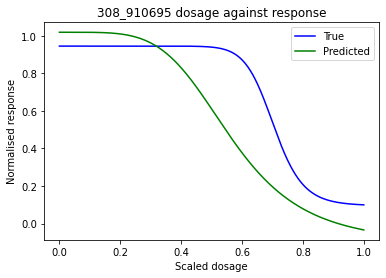

[-2.29940123  0.96849336  3.36458754 -0.13237063]


<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


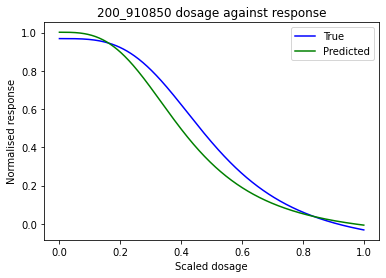

<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


[-5.08716977  0.99403073  9.78323821  0.05149893]


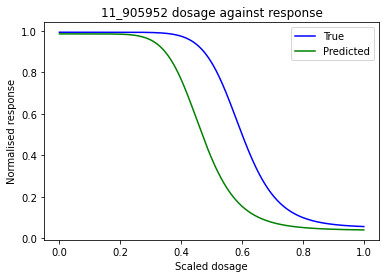

<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


[-1.50723035e+01  9.83986521e-01  2.00695525e+01  1.41121151e-02]


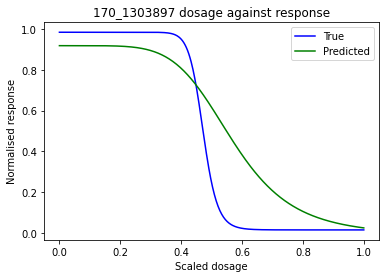

[-1.78828153  1.02609456  2.84335206 -0.06456188]


<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


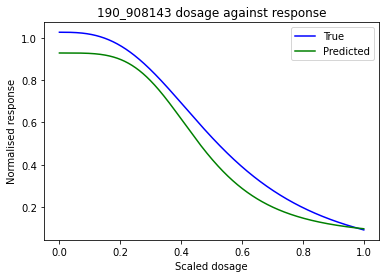

[-2.18379114  1.02319007  7.31162952 -0.01139085]


<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


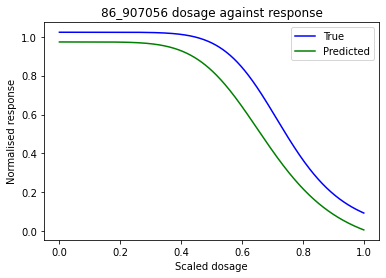

<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


[-9.71976813e+01  1.00769413e+00  2.44948586e+02  7.97430277e-02]


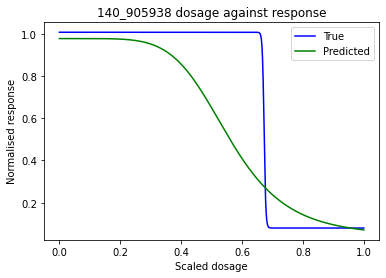

<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


[-9.72871233  0.99972457  6.79886645  0.02395913]


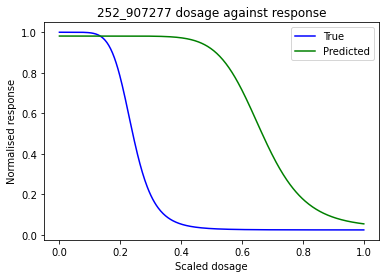

[-5.4936172   0.93609034  8.06025196 -0.01136033]


<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-87-c74e8c886443>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


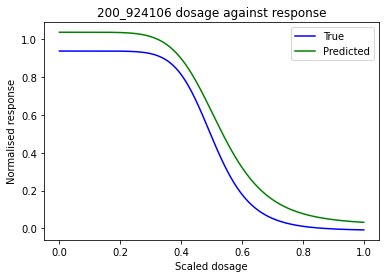

In [92]:
max_int = len(predictedOptimal.index)
rand_int = np.random.randint(0, max_int, 9)
for index in rand_int:
    showTestPredResponses(predictedOptimal.loc[index]['DRUG_COSMICID'])